In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The Data for this project was initially collected from reddit.com/r/wallstreetbets using the PSAW wrapper around the reddit API. This allowed for the collection of the historical data.

The data was entered into a postgresql database hosted on a local docker container. There are two corresponding tables: one for the posts, and one for the comments. Once the data was fully scraped back to Jan. '16 

Used Bernoulli sampling to create a training and validation dataset on which to do LDA topic modeling.

I chose to split the data by time ranges:
- training: 2016-01-01 ~ 2020-12-01
- testing: 2020-12-02 ~ 2021-02-01



In [2]:
!pip install demoji

     |████████████████████████████████| 42 kB 808 kB/s 


In [3]:
import demoji

In [4]:
import pandas as pd
import numpy as np
import pathlib
import re


import gensim
import gensim.corpora as corp
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from collections import Counter
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
stopwords_dict = Counter(stop_words)

In [6]:
import spacy
spacy.require_gpu()

True

In [117]:
from wordcloud import wordcloud
import matplotlib.pyplot as plt

In [7]:
path = pathlib.Path.cwd()
file_loc = path / 'gdrive/My Drive'
file_loc

PosixPath('/content/gdrive/My Drive')

In [19]:
df = pd.read_csv(file_loc/'2016_2020_12_training_bernoulli.csv')

In [20]:
df.head()

,id,dt,thetype,body
0,k4wehp,2020-12-01 23:59:48,post,Diamond hands on Chinese EVs The Senate Bill a...
1,k4wehp,2020-12-02 00:01:58,comment,[removed]
2,k4wehp,2020-12-02 00:09:20,comment,I cancelled my orders withdrawing the initial ...
3,k4wehp,2020-12-02 00:13:57,comment,The main issue is that everyone will be sellin...
4,k4wehp,2020-12-02 00:15:15,comment,I agree that it will take time before any deli...


Setting out with the intention of topic modeling, the goal of data wrangling here will be to remove stop words, and identify patterns in text that might obfuscate the detection of topics.

Of interest is identifying topics that might correlate in frequency or appearance to shifts in the price of stocks around GameStop prior to the Jan '21 short squeeze.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311516 entries, 0 to 2311515
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id       object
 1   dt       object
 2   thetype  object
 3   body     object
dtypes: object(4)
memory usage: 70.5+ MB


In [22]:
df.thetype = df.thetype.astype('category')

In [23]:
df.thetype.value_counts()

comment    2251345
post         60171
Name: thetype, dtype: int64

In [24]:
df.dt = pd.to_datetime(df.dt)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311516 entries, 0 to 2311515
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   id       object        
 1   dt       datetime64[ns]
 2   thetype  category      
 3   body     object        
dtypes: category(1), datetime64[ns](1), object(2)
memory usage: 55.1+ MB


In [26]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('[removed]', 54533), ('[deleted]', 40912), ('Yes', 3666), ('F', 3481), ('Ban', 2258), ('Lol', 2175), ('No', 1620), ('Nice', 1452), ('In order to promote quality discussion, your post has been removed for being too short. Please resubmit your thoughts with more detail, context, and value-add commentary.If you are sharing a link, make sure to provide ample context for your submition.*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*', 1383), ('lol', 1209)]
[('Hi', 1192), ('Same', 1065), ('yes', 1027), ('Ok', 1000), ('Yeet', 970), ('This is the way', 951), ('Lmao', 865), ('Mod me', 791), ('Why?', 651), ('Why', 578)]
[("Sorry, your post has been removed by vote. Please don't delete the post if you think it's not spam as it may be approved later.___You can either contact moderators or vote to restore this thread and punish the volunteer moderators respon

Initial insights into the text:
  There are a lot of removed or deleted comments/posts from the data set. These values will eventually be removed outright as they do not add any additional information.

  There are emojis that need to be either removed, or enocoded to text. -> will be using the demoji library to replace emojis with their decriptions. Much or some of the emoji usage within each post/comment seems almost like natural speech.

  There is an obscene amount of crass/inappropriate language, and I would be shocked to hear anyone use this type of language in person.

  There are quite a few comments to posts or responses to other comments that are interventions by bots. I will go ahead and remove these.

  Furthermore there are also quite a few links to youtube or references by bots to conduct rules. These should be removed.

In [27]:
df.isna().any()

id         False
dt         False
thetype    False
body        True
dtype: bool

In [28]:
df[df.body.isna()]

,id,dt,thetype,body
431962,igeuci,2020-08-25 19:05:25,comment,NaN
892583,hdpp7j,2020-06-22 10:36:49,comment,NaN
1590477,f9h6jj,2020-02-25 14:17:06,comment,NaN
2271585,5sqwnl,2017-03-13 09:24:04,comment,NaN
2307085,49kjo1,2016-03-08 22:00:27,comment,NaN


There are 5 instances of missing text for only comments. Therefore, these entries will be dropped prior to text preprocessing.

In [29]:
df.dropna(inplace=True)

In [30]:
df.shape

(2311511, 4)

In [31]:
def replace_emoji(sentence):
  found_emoji = demoji.findall(sentence)
  if len(found_emoji.keys()) !=0:
   sentence = demoji.replace_with_desc(sentence, sep='')
  return sentence

def replace_bot_text(sentence):
  if 'i am a bot' in sentence.lower():
    sentence = 'bot response'
  return sentence

def remove_link(sentence):
  sentence = re.sub('\S*\.com*\S*\s?', '', sentence)
  return sentence

def replace_bot_text(sentence):
  if 'i am a bot' in sentence.lower():
    sentence = 'bot response'
  elif 'wsbvotebot' in sentence.lower():
    sentence = 'bot response'
  return sentence

def conjugate_operations(sentence):
  sentence = replace_bot_text(sentence)
  sentence = remove_link(sentence)
  sentence = replace_emoji(sentence)
  return sentence
 

In [32]:
df['body'] = df['body'].apply(conjugate_operations)

In [33]:
df.head()

,id,dt,thetype,body
0,k4wehp,2020-12-01 23:59:48,post,Diamond hands on Chinese EVs The Senate Bill a...
1,k4wehp,2020-12-02 00:01:58,comment,[removed]
2,k4wehp,2020-12-02 00:09:20,comment,I cancelled my orders withdrawing the initial ...
3,k4wehp,2020-12-02 00:13:57,comment,The main issue is that everyone will be sellin...
4,k4wehp,2020-12-02 00:15:15,comment,I agree that it will take time before any deli...


In [34]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('[removed]', 54540), ('[deleted]', 40913), ('bot response', 14708), ('', 5591), ('Yes', 3667), ('F', 3481), ('Ban', 2258), ('Lol', 2175), ('No', 1620), ('Nice', 1452)]
[('lol', 1216), ('Hi', 1192), ('Same', 1065), ('yes', 1027), ('Ok', 1000), ('Yeet', 970), ('This is the way', 951), ('Lmao', 866), ('Mod me', 791), ('Why?', 651)]
[('Why', 578), ('This', 543), ('.', 530), ('Hello', 523), ('Yup', 519), ('no', 514), ('Me', 514), ('ban', 510), ('face with tears of joy', 508), ('RIP', 503)]
[('LOL', 502), ('Yo', 476), ('Yes.', 458), ('Thanks', 440), ('Yep', 434), ('Bet', 430), ('?', 429), ('Priced in', 427), ('Oof', 406), ('Source?', 403)]
[(' ', 401), ('Rip', 398), ('K', 398), ('Wow', 392), ('Mod', 392), ('nice', 388), ('What', 383), ('This is the way.', 381), ('GUH', 380), ('lmao', 371)]
[('Nope', 346), ('Sure', 326), ('ok', 326), ('Cool', 322), ('Link?', 310), ('Hey', 308), ('Comment', 307), ('Bruh', 303), ('hi', 296), ('Gay', 289)]
[('Positions?', 284), ('What?', 284), ('Username check

Removing links and replacing emjoi with their descriptions has concentrated occurences. We can also see that replace the autogenerated bot comments has revealed 14708 instances of bot comments.

additionally we can see that there are 5591 instances of empty strings, and 401 instances of extra spaces.

In [35]:
df[df.thetype == 'post'].id.duplicated().value_counts()

False    60171
Name: id, dtype: int64

A check to make sure that there are no duplicate posts, i.e. during the random sampling of the data from the database no id was selected more than once.

In [36]:
#checking to see where the text is only deleted or removed
rd_res = df[(df['body'] == '[deleted]') | (df['body'] == '[removed]')]

In [37]:
rd_res.thetype.value_counts()

comment    95445
post           8
Name: thetype, dtype: int64

In [38]:
rd_res[rd_res['thetype'] == 'post']

,id,dt,thetype,body
1039361,gwz84w,2020-06-05 08:25:32,post,[removed]
1204835,g38ef0,2020-04-17 21:10:55,post,[removed]
1204837,g38dty,2020-04-17 21:10:03,post,[removed]
1480446,flip8p,2020-03-19 22:56:14,post,[removed]
1690616,ejsjhw,2020-01-04 06:45:25,post,[removed]
1813421,cym71t,2019-09-02 10:11:35,post,[removed]
1840805,cqt0af,2019-08-15 19:28:18,post,[removed]
2309995,42nmdz,2016-01-25 21:47:58,post,[deleted]


The text field of both the posts and comments when collected from the API were nullable. The above results suggest that there are 8 instances where a post was deleted or removed, leaving no information about the post title or the body of the post. 

We shall remove this instances from the data set, as we can further distinguish these from posts where the body was deleted or removed, and the title information was retained. These will be kept as they still offer insight into the community discourse at the time of their posting. We will however be removing these words from the dataset using regular expressions to exactly match the pattern.

With regard to the 95445 comments that were removed or deleted. These will also be removed as they offer nothing to the problem of determining the discussion topics.

In [39]:
df = df[~df.index.isin(rd_res.index)].copy()

In [42]:
def remove_deleted_text(sentence):
  return re.sub(r'\s\[.*?\]', '', sentence)
  

In [43]:
df.body = df.body.apply(lambda x: remove_deleted_text(x))

In [44]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('bot response', 14708), ('', 5591), ('Yes', 3667), ('F', 3482), ('Ban', 2258), ('Lol', 2175), ('No', 1620), ('Nice', 1453), ('lol', 1217), ('Hi', 1192)]
[('Same', 1065), ('yes', 1027), ('Ok', 1000), ('Yeet', 970), ('This is the way', 951), ('Lmao', 866), ('Mod me', 791), ('Why?', 651), ('Why', 578), ('This', 543)]
[('.', 532), ('Hello', 525), ('Yup', 519), ('Me', 516), ('no', 514), ('ban', 510), ('face with tears of joy', 508), ('RIP', 504), ('LOL', 502), ('Yo', 476)]
[('Yes.', 458), ('Thanks', 440), ('Yep', 435), ('?', 430), ('Bet', 430), ('Priced in', 427), ('Oof', 407), ('Source?', 403), (' ', 401), ('Rip', 398)]
[('K', 398), ('Wow', 392), ('Mod', 392), ('nice', 389), ('What', 383), ('This is the way.', 381), ('GUH', 380), ('lmao', 371), ('Nope', 346), ('Sure', 326)]
[('ok', 326), ('Cool', 322), ('Link?', 310), ('Hey', 309), ('Comment', 307), ('Bruh', 303), ('hi', 297), ('Gay', 289), ('Positions?', 284), ('What?', 284)]
[('Username checks out', 284), ('Hold', 282), ('Nah', 282), (

In [51]:
char_instances = df[(df.body == '') |(df.body == '.') | (df.body == ' ') | (df.body == '.') | (df.body == '?') | (df.body == '...') | (df.body == ':)') | (df.body == ':(')]

In [52]:
char_instances.thetype.value_counts()

comment    7545
post          8
Name: thetype, dtype: int64

In [53]:
char_instances[char_instances.thetype == 'post']

,id,dt,thetype,body
1241460,g2hyn3,2020-04-16 18:16:02,post,:)
1663197,er63lv,2020-01-20 02:51:28,post,
1713519,eddh0c,2019-12-20 18:51:29,post,.
1831017,cvbyz4,2019-08-25 20:12:14,post,
2133836,9xo1dc,2018-11-16 18:08:42,post,
2178874,90j06w,2018-07-20 21:30:58,post,
2213054,7szpt3,2018-01-25 22:55:09,post,.
2300072,4krz54,2016-05-24 05:50:07,post,?


Looking more closely at the patterns we have seen, there are 7553 posts and comments that are either empty strings, extra spaces, or forms of punctuation that do not add any contextual information that could lead to understanding/discerning of topics; therefore these will all be removed.

In [55]:
df = df[~df.index.isin(char_instances.index)].copy()

At this point we are honing in on the discourse of the community. We can see that there are 14708 instances of auto generated comments by bots in response to posts or comments by other contributors. Again this information doesn't actually expose any real information around the discourse and will be removed. 

Furthermore we are starting to see instances of punctuation and numbers making their way into the text. 

In [ ]:
bot_responses = df[df.body =='bot response']
bot_responses

In [57]:
bot_responses.thetype.value_counts()

comment    14518
post         190
Name: thetype, dtype: int64

We can see that there are roughly 14.5k comments made by bots, and roughly 190 posts made by the wsbvotebot.

Knowing that there are posts made by bots to gather community opinion/provide a forum for discussion, we can see that there are roughly 532 of such posts. These will be removed. As they don't add to the discussion, since they are generally not motivated by anything in particular, they are simply a place for people to interact within the community.

In [58]:
df = df[~df.index.isin(bot_responses.index)].copy()

At this point we are finally at a place where we can start lemmatizing the texts

In [59]:
df['body'] = df['body'].apply(lambda x: simple_preprocess(str(x),deacc=True))

In [61]:
df.to_csv(file_loc/'preprocessed_training.csv') #ram is getting low, cautionary save

In [ ]:
df = pd.read_csv(file_loc/'preprocessed_training.csv')

Below begin creating the bigrams after the simple preprocessing is done

In [62]:
content = df.body.values.tolist()

In [63]:
bigram = gensim.models.Phrases(content, min_count=5, threshold=100) # could potentially grid search this.
trigram = gensim.models.Phrases(bigram[content], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mode = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [106]:
nlp = spacy.load('en', disable =['ner','parser'])


In [112]:
def remove_sw(sentences):
    new_sentences = [[word for word in sentence if word not in stopwords_dict] for sentence in sentences]
    return new_sentences

def make_bigrams(sentences):
    bigrams = [bigram_mod[sentence] for sentence in sentences]
    return bigrams
def make_trigrams(sentences):
  trigrams = [trigram_mode[sentence] for sentence in sentences]
  return trigrams


def do_lemmatization(doc, pos_tags =['NOUN','ADJ','VERB','ADV']):
    """will do lemmatization using the pipe on all of the texts as once"""
    lemmatized_list = [token.lemma_ for token in doc if token.pos_ in pos_tags]
    return lemmatized_list

def preproc_pipe(texts):
  outputs = []
  for doc in nlp.pipe(texts, disable=['parser','ner'], batch_size=1000):
    outputs.append(do_lemmatization(doc))
  return outputs




In [66]:
content_no_sw = remove_sw(content)

In [69]:
content_bigrams = make_bigrams(content_no_sw)
content_trigrams = make_trigrams(content_bigrams)

In [70]:
del(content)
del(content_no_sw)
del(content_bigrams)

In [71]:
df['tri_grams'] = content_trigrams
del(content_trigrams)
df['tri_grams'] = df.tri_grams.apply(lambda x: ' '.join(x))

In [72]:
df.to_csv(file_loc/'preprocessed_training.csv')

In [113]:
df['preprocessed'] = preproc_pipe(df['tri_grams'])

In [115]:
df.to_csv(file_loc/'preprocessed_training.csv')

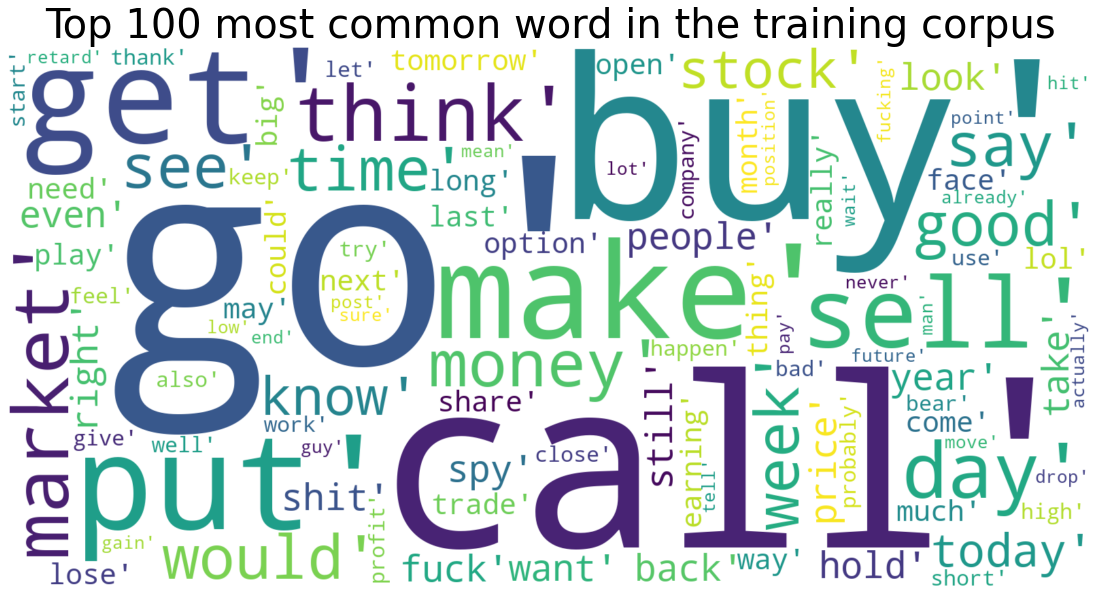

In [130]:
wrdlst = []
for item in df.preprocessed.values:
  wrdlst.extend(item)


most_common = nltk.probability.FreqDist(wrdlst).most_common(100)
wrdcld = wordcloud.WordCloud(width=1600, height= 800, background_color='white')\
.generate(str(most_common))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wrdcld, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common word in the training corpus', fontsize=40)

plt.show()
